# Software Undergound Rendezvous: Feb 6 2021
## Importance of noise estimates when solving inverse problems in the "real" world
## Part 1 Generate results for analysis
### Sean Walker

----

## Import modules


In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import pickle

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colors

from scipy.stats import gmean

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz, extract_core_mesh

from SimPEG.utils import surface2ind_topo
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    apparent_resistivity,
    source_receiver_midpoints
)

from scripts.dc_inv_utils import *

try:
    from pymatsolver.direct import Pardiso as Solver
    print('Using Paradiso Solver')
except ImportError:
    print('Using LU Solver')
    from SimPEG import SolverLU as Solver


Using Paradiso Solver
Using Paradiso Solver


**Note** when using the Paradiso solver you may get many warnings that make it hard to read the inversion output. You need at turn off warnings by setting a variable.

On mac\/\*nx: export KMP_WARNINGS=0  (can be inlcuded in a profile file)

On windows: set KMP_WARNINGS=0 (can be set as an environment variable)

----

## Demonstrate using DC Resistivity data

### SimPEG 2.5D DC Resistivity Least-Squares Inversion

Here we invert a line of DC resistivity data to recover an electrical conductivity model. 
We formulate the corresponding inverse problems as least-squares optimization problems. For this tutorial, I am going to ignore pretty much all of specifics of how the invesion is set up and runs except the for data misfit.

Short intro to DC Resistivity data is here:

![Image](https://gpg.geosci.xyz/_images/Pseudo_PDP_East.gif)

You can find background on [DC Resistivity](https://gpg.geosci.xyz/content/DC_resistivity/index.html) data at [Geophysics for Practicing Geoscientists](https://gpg.geosci.xyz). The image is from the GPG website.



Short intro to Least-Squares Inversion:



You can find a [SimPEG](https://simpeg.xyz/) DC Resisivity inversion tutorial [here](https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_inv_2_dcr2d.html#sphx-glr-content-tutorials-05-dcr-plot-inv-2-dcr2d-py)

## Load Data and define Survey

Here we load the observed data and define the DC and IP survey geometry.




In [4]:
# load data

# path to the directory containing our data
data_path = Path('data')

# files to work with
topo_filename = Path(data_path / "rv_dipole_dipole_topo.txt")
dc_data_filename = Path(data_path / "rv_dipole_dipole_dc.txt")

# load files
topo_xz = np.loadtxt(topo_filename)
dobs_dc = np.loadtxt(dc_data_filename)

# Extract source and receiver electrode locations and the observed data
#  we are assuming the dc and ip tx-rx pairs are the same. In this case they are.
A_electrodes = np.c_[dobs_dc[:, 0], np.zeros(dobs_dc.shape[0])]
B_electrodes = np.c_[dobs_dc[:, 1], np.zeros(dobs_dc.shape[0])]
M_electrodes = np.c_[dobs_dc[:, 2], np.zeros(dobs_dc.shape[0])]
N_electrodes = np.c_[dobs_dc[:, 3], np.zeros(dobs_dc.shape[0])]
dobs_dc = dobs_dc[:, -1]

# Define survey
unique_tx, k = np.unique(np.c_[A_electrodes, B_electrodes], axis=0, return_index=True)
n_sources = len(k)
k = np.r_[k, len(A_electrodes) + 1]

source_list = []
for ii in range(0, n_sources):

    # MN electrode locations for receivers. Each is an (N, 3) numpy array
    M_locations = M_electrodes[k[ii] : k[ii + 1], :]
    N_locations = N_electrodes[k[ii] : k[ii + 1], :]
    receiver_list = [dc.receivers.Dipole(M_locations, N_locations, data_type="volt")]

    # AB electrode locations for source. Each is a (1, 3) numpy array
    A_location = A_electrodes[k[ii], :]
    B_location = B_electrodes[k[ii], :]
    source_list.append(dc.sources.Dipole(receiver_list, A_location, B_location))

# Define survey
dc_survey = dc.survey.Survey(source_list)

# Define the a data object. Uncertainties are added later
dc_data = data.Data(dc_survey, dobs=dobs_dc)

# Calc app res and midx and mad mid_z used in plotting pseudo sections
app_res = apparent_resistivity(dc_data)
app_res_mean = gmean(app_res)
mid_x, mid_z = source_receiver_midpoints(dc_survey)

We now have a `Data` object and a `Survey` object for the DC resistivity data. We also calculated apparent resistivity and mid points/pseudo depths from the array to plot the data.

Now set up the mesh and define the active part of the model

In [5]:
# Mesh
# all thes values were determined by looking at the data set
#  there are probably 
core_x_min = 0
core_x_max = 1900
core_x_width = core_x_max - core_x_min
core_z_min = -600
core_z_max = 0
core_z_width = core_z_max - core_z_min

dh = 12.5  # base cell width 25m / 4
x_min = -500.  # domain width x
x_max = 2400.
dom_width_x = x_max - x_min
z_max = 0.
z_min = -1100.
dom_width_z = z_max - z_min
# Calculate num. base cells x and z must be powers of 2 of base cell
#  for tree mesh
nbcx = 2 ** int(np.ceil(np.log(dom_width_x / dh) / np.log(2.0)))
nbcz = 2 ** int(np.ceil(np.log(dom_width_z / dh) / np.log(2.0)))
# calculate the actual size of the mesh from on number of base cells.
actual_x_width = nbcx*dh
actual_z_width = nbcz*dh
# define the origin
x_origin = core_x_min - (actual_x_width - core_x_width)/2
z_origin = -1*actual_z_width
# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0=[x_origin, z_origin])
# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh, topo_xz, octree_levels=[1], method="surface", finalize=False
)

# Mesh refinement near transmitters and receivers
electrode_locations = np.r_[
    dc_survey.locations_a,
    dc_survey.locations_b,
    dc_survey.locations_m,
    dc_survey.locations_n,
]

unique_locations = np.unique(electrode_locations, axis=0)

mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[2, 4], method="radial",
    finalize=False)

# Refine core mesh region
xp, zp = np.meshgrid([core_x_min, core_x_max], [core_z_min, core_z_max])
xyz = np.c_[mkvc(xp), mkvc(zp)]
mesh = refine_tree_xyz(mesh, xyz, octree_levels=[0, 2, 2], method="box",
                       finalize=False)

mesh.finalize()

# Find cells that lie below surface topography
ind_active = surface2ind_topo(mesh, topo_xz)

# Shift electrodes to the surface of discretized topography
dc_survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
# bacground value we will use the mean apparent resistivity
background_conductivity = np.log(1/app_res_mean)

active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

conductivity_map = active_map * maps.ExpMap()

# Define model
starting_conductivity_model = background_conductivity * np.ones(nC)

plotting_map = maps.ActiveCells(mesh, ind_active, np.nan)


In [6]:
# mesh core
core_defn=[core_x_min, core_x_max, core_z_min, core_z_max]
# Electrode locs (re-calc)
electrode_locations = np.r_[
    dc_survey.locations_a,
    dc_survey.locations_b,
    dc_survey.locations_m,
    dc_survey.locations_n,
]

unique_locations = np.unique(electrode_locations, axis=0)

## Store results and other files for use in discussion

In [7]:
# path to the directory containing our results
results_path = Path('results')

In [8]:
# Pickle stuff we need for setting up the problem and running inversions
#  start by putting it in a dict
out_fields = ['mesh', 'dc_survey', 'dc_data', 'starting_conductivity_model', 'plotting_map', 'conductivity_map', 'ind_active',
                'core_defn', 'unique_locations', 'app_res_mean', 'app_res', 'mid_x', 'mid_z']
out_values = [mesh, dc_survey, dc_data, starting_conductivity_model, plotting_map, conductivity_map, ind_active,
                core_defn, unique_locations, app_res_mean, app_res, mid_x, mid_z]
out_dict = dict(zip(out_fields, out_values))

# setup file name
setup_filename = Path(results_path / "setup.pkl")

save_results_dict(out_dict, setup_filename)

## Assign Uncertainties

Inversion with SimPEG requires that we define standard deviation on our data.
This represents our estimate of the noise in our data.

These values are used to form the data weighting matrix Wdii = 1/stdii

We need to choose a value.

5% is fairly common starting point. But why not 10% or 1%?

Should the large offsets have larger errors (n = 4,5: 15%  and n = 6: 20%?).

Should the error estimate have a minimum value sometimes called a noise floor? We choose this as an actual noise floor: 2 * noise level? Or a samll number to prevent 1/std being too large 1e-6?


## Run a bunch of inversions to see what happens

Plot phi_d and phi_m from the various inversions.

Choose an optimal beta based on the curve flattening out.

Show that while phi_d is different for each of these the model is the same.

Good reminder of why choosing an arbitrary error estimate and ftiing to your theoretical target misfit is a bad idea.

### Test #1: Change the percentage

Run inversion with 5 and 10%

Plot errors as Voltages in pseudo section and histogram 

Based on the phi_d equation we should be able see that the relative errors are the same for each (1/data amplitude). The difference is a constant (1/percentage). So the shape of the phi_d and phi_m curves should be the same. The amplitudes and beta values will be different.



In [9]:
# Compute standard deviations
std_dc_5_per = 0.05 * np.abs(dc_data.dobs)
# run inversion
out_5_per, out_all_5_per = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_dc_5_per,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)



        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.39e+05  3.67e+04  0.00e+00  3.67e+04    7.10e+03      0              
   1  1.39e+04  1.66e+04  4.96e-02  1.73e+04    2.74e+03      0              
   2  1.39e+03  8.20e+03  3.14e-01  8.64e+03    1.16e+03      0   Skip BFGS  
   3  1.39e+02  4.62e+03  1.43e+00  4.82e+03    5.93e+02      0   Skip BFGS  
   4  1.39e+01  2.63e+03  6.10e+00  2.72e+03    2.60e+02      0   Skip BFGS  
   5  1.39e+00  1.79e+03  1.49e+01  1.81e+03    1.90e+02      0   Skip BFGS  
   6  1.39e-01  1.36e+03  2.06e+01  1.37e+03    2.01e+02      0              
   7  1.39e-02  1.02e+03  2.90e+01

In [10]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_5_per.phi_d, out_5_per.phi_m, out_5_per.beta, out_all_5_per.outDict, std_dc_5_per]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_dc_5_per_filename = Path(results_path / "inv_std_dc_5_per.pkl")

save_results_dict(out_dict, inv_std_dc_5_per_filename)

In [11]:
# Compute standard deviations for 10 % inversion
std_dc_10_per = 0.10 * np.abs(dc_data.dobs)
# run inversion
out_10_per, out_all_10_per = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_dc_10_per,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.47e+04  9.17e+03  0.00e+00  9.17e+03    1.78e+03      0              
   1  3.47e+03  4.16e+03  4.94e-02  4.33e+03    6.86e+02      0              
   2  3.47e+02  2.05e+03  3.14e-01  2.16e+03    2.90e+02      0   Skip BFGS  
   3  3.47e+01  1.15e+03  1.43e+00  1.20e+03    1.48e+02      0   Skip BFGS  
   4  3.47e+00  6.58e+02  6.10e+00  6.79e+02    6.51e+01      0   Skip BFGS  
   5  3.47e-01  4.48e+02  1.49e+01  4.53e+02    4.74e+01      0   Skip BFGS  
   6  3.47e-02  3.41e+02  2.06e+01  3.42e+02    5.04e+01      0              
   7  3.47e-03  2.55e+02  2.95e+01

In [12]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_10_per.phi_d, out_10_per.phi_m, out_10_per.beta, out_all_10_per.outDict, std_dc_10_per]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_dc_10_per_filename = Path(results_path / "inv_std_dc_10_per.pkl")

save_results_dict(out_dict, inv_std_dc_10_per_filename)

### Test #2: Variable percentage

Run inversion n <= 3: 10%, 3 < n <= 5: 15%, n > 5: 20%
Run inversion n <= 3: 5%, 3 < n <= 4: 10%, n > 4: 15%

Plot errors as Voltages in pseudo section and histogram 

Errors are different so we would expect inversion to behave differently.

In [13]:
# Calculate the n-values
n_val = mid_z/50
# Compute standard deviations
std_var_per_1 = np.zeros(len(n_val))
std_var_per_1[abs(n_val) <= 3] = 0.1
std_var_per_1[(abs(n_val) > 3) & (abs(n_val) <= 5)] = 0.15
std_var_per_1[abs(n_val) > 5] = 0.2
std_var_per_1 *= np.abs(dc_data.dobs)
# run inversion
out_var_per_1, out_all_var_per_1 = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_var_per_1,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.22e+04  8.08e+03  0.00e+00  8.08e+03    1.70e+03      0              
   1  3.22e+03  3.73e+03  4.95e-02  3.89e+03    6.47e+02      0              
   2  3.22e+02  1.89e+03  3.03e-01  1.99e+03    2.72e+02      0   Skip BFGS  
   3  3.22e+01  1.03e+03  1.43e+00  1.08e+03    1.35e+02      0   Skip BFGS  
   4  3.22e+00  5.32e+02  6.10e+00  5.52e+02    5.53e+01      0   Skip BFGS  
   5  3.22e-01  3.60e+02  1.26e+01  3.64e+02    3.95e+01      0   Skip BFGS  
   6  3.22e-02  2.94e+02  1.70e+01  2.95e+02    3.99e+01      0              
   7  3.22e-03  2.41e+02  2.42e+01

In [15]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_var_per_1.phi_d, out_var_per_1.phi_m, out_var_per_1.beta, out_all_var_per_1.outDict, std_var_per_1]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_var_per_1_filename = Path(results_path / "inv_std_var_per_1.pkl")

save_results_dict(out_dict, inv_std_var_per_1_filename)

In [16]:
# Compute standard deviations
std_var_per_2 = np.zeros(len(n_val))
std_var_per_2[abs(n_val) <= 3] = 0.05
std_var_per_2[(abs(n_val) > 3) & (abs(n_val) <= 4)] = 0.10
std_var_per_2[abs(n_val) > 4] = 0.15
std_var_per_2 *= dc_data.dobs
# run inversion
out_var_per_2, out_all_var_per_2 = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_var_per_2,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.26e+05  3.07e+04  0.00e+00  3.07e+04    6.73e+03      0              
   1  1.26e+04  1.42e+04  4.82e-02  1.48e+04    2.56e+03      0              
   2  1.26e+03  7.20e+03  2.99e-01  7.58e+03    1.07e+03      0   Skip BFGS  
   3  1.26e+02  3.80e+03  1.48e+00  3.98e+03    5.10e+02      0   Skip BFGS  
   4  1.26e+01  1.85e+03  6.29e+00  1.92e+03    1.95e+02      0   Skip BFGS  
   5  1.26e+00  1.22e+03  1.29e+01  1.23e+03    1.61e+02      0   Skip BFGS  
   6  1.26e-01  1.04e+03  1.53e+01  1.04e+03    1.29e+02      0              
   7  1.26e-02  8.97e+02  1.97e+01

In [17]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_var_per_2.phi_d, out_var_per_2.phi_m, out_var_per_2.beta, out_all_var_per_2.outDict, std_var_per_2]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_var_per_2_filename = Path(results_path / "inv_std_var_per_2.pkl")

save_results_dict(out_dict, inv_std_var_per_2_filename)

### Test #3: % and floor

Run inversion 5% + 5% of std dev
Run inversion 5% + 2 * smallest value

Plot errors as Voltages in pseudo section and histogram 

Errors are different so we would expect inversion to behave differently.

In [21]:
# Compute standard deviations
# 5 per of data + 5 % of std dev
std_per_flr_1 = 0.05 * np.abs(dc_data.dobs) + 0.05 * np.std(dc_data.dobs)

# run inversion
out_per_flr_1, out_all_per_flr_1 = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_per_flr_1,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.36e+03  1.24e+03  0.00e+00  1.24e+03    1.12e+02      0              
   1  2.36e+02  9.32e+02  6.48e-02  9.47e+02    8.20e+01      0              
   2  2.36e+01  4.98e+02  7.39e-01  5.16e+02    6.88e+01      0   Skip BFGS  
   3  2.36e+00  1.85e+02  3.76e+00  1.94e+02    3.96e+01      0   Skip BFGS  
   4  2.36e-01  4.94e+01  9.62e+00  5.17e+01    4.31e+01      0              
   5  2.36e-02  2.40e+01  8.33e+00  2.42e+01    7.26e+00      0              
   6  2.36e-03  1.94e+01  9.39e+00  1.94e+01    1.18e+01      0              
   7  2.36e-04  1.65e+01  9.42e+00

In [22]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_per_flr_1.phi_d, out_per_flr_1.phi_m, out_per_flr_1.beta, out_all_per_flr_1.outDict, std_per_flr_1]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_per_flr_1_filename = Path(results_path / "inv_std_per_flr_1.pkl")

save_results_dict(out_dict, inv_std_per_flr_1_filename)

Using Paradiso Solver


In [23]:
# Compute standard deviations
# 5 per of data + 2 * min
std_per_flr_2 = 0.05 * np.abs(dc_data.dobs) + 2 * dc_data.dobs.min()

# run inversion
out_per_flr_2, out_all_per_flr_2 = setup_and_run_std_inv(mesh, dc_survey, dc_data, std_per_flr_2,
                                                 conductivity_map, ind_active,
                                                 starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.39e+04  7.39e+03  0.00e+00  7.39e+03    1.53e+03      0              
   1  2.39e+03  4.59e+03  4.59e-02  4.70e+03    6.64e+02      0              
   2  2.39e+02  2.41e+03  5.66e-01  2.55e+03    3.17e+02      0   Skip BFGS  
   3  2.39e+01  1.17e+03  2.56e+00  1.23e+03    1.99e+02      0   Skip BFGS  
   4  2.39e+00  4.15e+02  7.42e+00  4.33e+02    6.98e+01      0   Skip BFGS  
   5  2.39e-01  2.43e+02  1.20e+01  2.46e+02    5.15e+01      0   Skip BFGS  
   6  2.39e-02  2.06e+02  1.34e+01  2.06e+02    3.10e+01      0              
   7  2.39e-03  1.76e+02  1.73e+01

In [24]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_per_flr_2.phi_d, out_per_flr_2.phi_m, out_per_flr_2.beta, out_all_per_flr_2.outDict, std_per_flr_2]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_per_flr_2_filename = Path(results_path / "inv_std_per_flr_2.pkl")

save_results_dict(out_dict, inv_std_per_flr_2_filename)

Using Paradiso Solver


Apply work flow to first example

In [80]:
# get phid from 1st iteration of 
# calc stats
dd_dc_5_per = (dc_data.dobs - out_all_5_per.outDict[1]['dpred']) / std_dc_5_per
mean_dd_dc_5_per = np.mean(dd_dc_5_per)
std_dd_dc_5_per = np.std(dd_dc_5_per)
# rescale errors
std_dc_5_per_recscale = (abs(dd_dc_5_per - mean_dd_dc_5_per)/std_dd_dc_5_per + 1) * std_dc_5_per

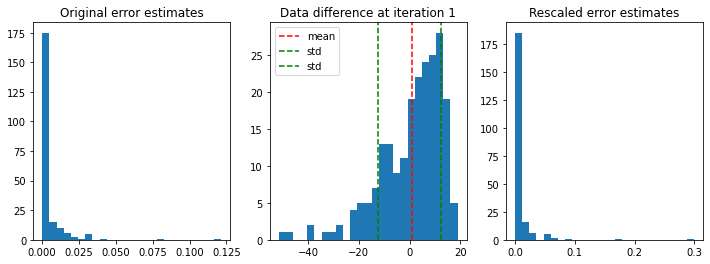

In [90]:
# plot the data difference as histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist(std_dc_5_per, bins=25)
ax1.set_title('Original error estimates')
ax2.hist(dd_dc_5_per, bins=25)
ylim = ax2.get_ylim()
ax2.plot(mean_dd_dc_5_per*np.ones(2), ylim, 'r--', label='mean')
ax2.plot(std_dd_dc_5_per*np.ones(2), ylim, 'g--', label='std')
ax2.plot(-1*std_dd_dc_5_per*np.ones(2), ylim, 'g--', label='std')
ax2.legend()
ax2.set_ylim(ylim)
ax2.set_title('Data difference at iteration 1')
ax3.hist(std_dc_5_per_rescale, bins=25)
ax3.set_title('Rescaled error estimates')
plt.show()

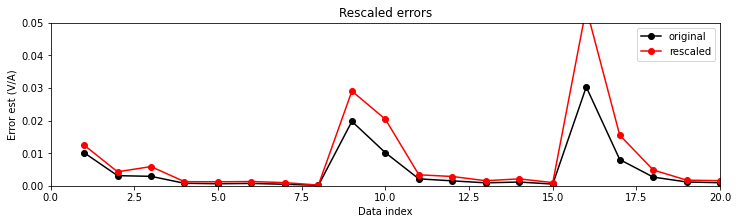

In [58]:
# plot the rescaled errors
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(np.linspace(1,len(std_dc_5_per),len(std_dc_5_per)), std_dc_5_per, 'ko-', label='original')
ax.plot(np.linspace(1,len(std_dc_5_per),len(std_dc_5_per)), std_dc_5_per_recscale, 'ro-', label='rescaled')
ax.legend()
ax.set_xlim(0,20)
ax.set_ylim(0,0.05)
ax.set_xlabel('Data index')
ax.set_ylabel('Error est (V/A)')
ax.set_title('Rescaled errors')
plt.show()

In [54]:
# run inversion
out_5_per_rescale, out_all_5_per_rescale = setup_and_run_std_inv(
    mesh, dc_survey, dc_data, std_dc_5_per_rescale, conductivity_map, ind_active,
    starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.76e+04  6.04e+03  0.00e+00  6.04e+03    7.95e+02      0              
   1  2.76e+03  3.46e+03  3.11e-02  3.54e+03    3.93e+02      0              
   2  2.76e+02  1.99e+03  2.61e-01  2.07e+03    2.43e+02      0   Skip BFGS  
   3  2.76e+01  1.10e+03  1.60e+00  1.14e+03    1.41e+02      0   Skip BFGS  
   4  2.76e+00  6.80e+02  5.92e+00  6.96e+02    6.86e+01      0   Skip BFGS  
   5  2.76e-01  4.87e+02  1.49e+01  4.91e+02    5.16e+01      0   Skip BFGS  
   6  2.76e-02  4.02e+02  1.74e+01  4.02e+02    4.62e+01      0              
   7  2.76e-03  3.10e+02  2.80e+01

In [83]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_5_per_rescale.phi_d, out_5_per_rescale.phi_m, out_5_per_rescale.beta, out_all_5_per_rescale.outDict, std_dc_5_per_rescale]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_5_per_rescale_filename = Path(results_path / "inv_std_5_per_rescale.pkl")

save_results_dict(out_dict, inv_std_5_per_rescale_filename)

Rescale again using iteration 3

In [86]:
# get phid from 1st iteration of 
# calc stats
dd_dc_5_per_rs = (dc_data.dobs - out_all_5_per_rescale.outDict[3]['dpred']) / std_dc_5_per_rescale
mean_dd_dc_5_per_rs = np.mean(dd_dc_5_per_rs)
std_dd_dc_5_per_rs = np.std(dd_dc_5_per_rs)
# rescale errors
std_dc_5_per_rescale_2 = (abs(dd_dc_5_per_rs - mean_dd_dc_5_per_rs)/std_dd_dc_5_per_rs + 1) * std_dc_5_per_rescale

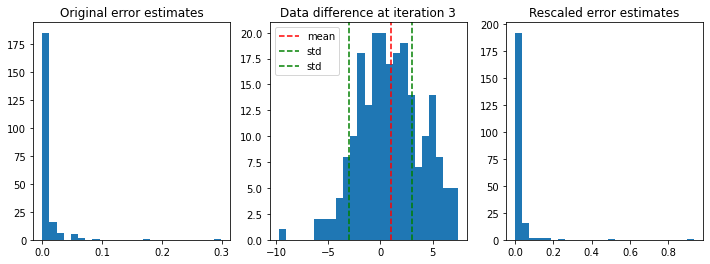

In [87]:
# plot the data difference as histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.hist(std_dc_5_per_rescale, bins=25)
ax1.set_title('Original error estimates')
ax2.hist(dd_dc_5_per_rs, bins=25)
ylim = ax2.get_ylim()
ax2.plot(mean_dd_dc_5_per_rs*np.ones(2), ylim, 'r--', label='mean')
ax2.plot(std_dd_dc_5_per_rs*np.ones(2), ylim, 'g--', label='std')
ax2.plot(-1*std_dd_dc_5_per_rs*np.ones(2), ylim, 'g--', label='std')
ax2.legend()
ax2.set_ylim(ylim)
ax2.set_title('Data difference at iteration 3')
ax3.hist(std_dc_5_per_rescale_2, bins=25)
ax3.set_title('Rescaled error estimates')
plt.show()

In [88]:
# run inversion
out_5_per_rescale_2, out_all_5_per_rescale_2 = setup_and_run_std_inv(
    mesh, dc_survey, dc_data, std_dc_5_per_rescale_2, conductivity_map, ind_active,
    starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.33e+04  2.22e+03  0.00e+00  2.22e+03    3.43e+02      0              
   1  1.33e+03  1.19e+03  2.65e-02  1.22e+03    1.62e+02      0              
   2  1.33e+02  5.40e+02  2.40e-01  5.71e+02    8.94e+01      0   Skip BFGS  
   3  1.33e+01  2.37e+02  1.15e+00  2.52e+02    4.37e+01      0   Skip BFGS  
   4  1.33e+00  1.61e+02  2.73e+00  1.65e+02    1.92e+01      0   Skip BFGS  
   5  1.33e-01  1.22e+02  6.73e+00  1.23e+02    1.70e+01      0   Skip BFGS  
   6  1.33e-02  1.09e+02  7.87e+00  1.09e+02    1.42e+01      0              
   7  1.33e-03  9.46e+01  1.42e+01

In [89]:
# Pickle inversion results
#  start by putting it in a dict
out_fields = ['phi_d', 'phi_m', 'beta', 'inv_out', 'std_dc']
out_values = [out_5_per_rescale_2.phi_d, out_5_per_rescale_2.phi_m, out_5_per_rescale_2.beta, out_all_5_per_rescale_2.outDict, std_dc_5_per_rescale_2]
out_dict = dict(zip(out_fields, out_values))

# setup file name
inv_std_5_per_rescale_2_filename = Path(results_path / "inv_std_5_per_rescale_2.pkl")

save_results_dict(out_dict, inv_std_5_per_rescale_2_filename)